# Explore here

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.metrics import root_mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf





In [2]:


data = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv")

sales = data.copy()

sales.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


In [3]:
# Convertimos el indice a formato Datetime

sales['date'] = pd.to_datetime(sales['date'])

sales.set_index('date', inplace = True)

sales.head()

,sales
date,
2022-09-03 17:10:08.079328,55.292157
2022-09-04 17:10:08.079328,53.803211
2022-09-05 17:10:08.079328,58.141693
2022-09-06 17:10:08.079328,64.530899
2022-09-07 17:10:08.079328,66.013633


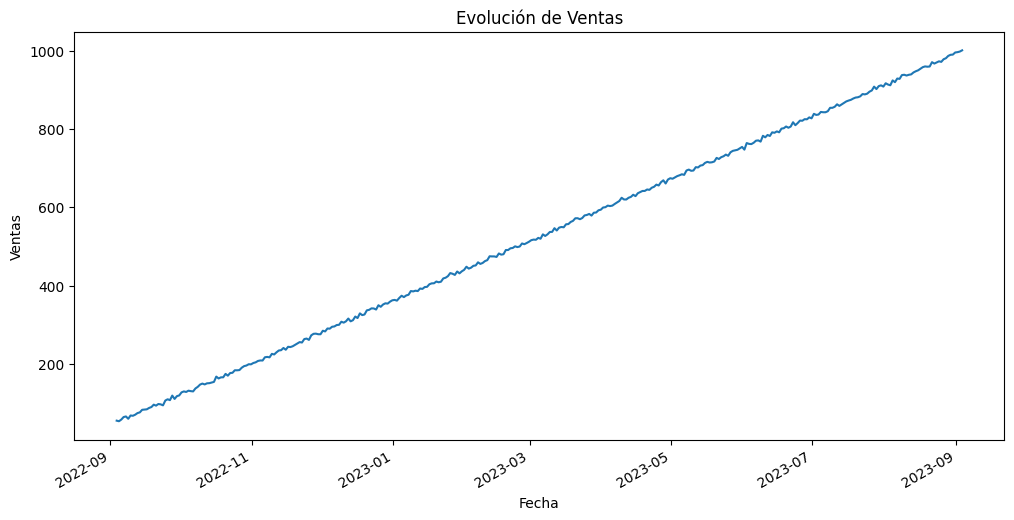

In [4]:

sales['sales'].plot(title="Evolución de Ventas", figsize=(12, 6))
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.show()

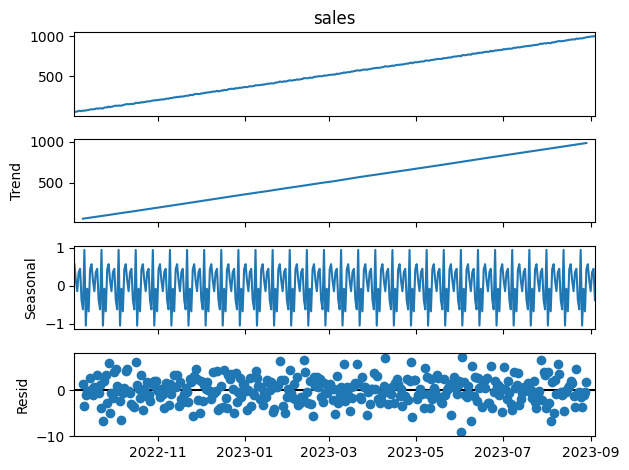

In [5]:
# Descomponemos la serie temporal
result = seasonal_decompose(sales['sales'], model='additive', period=12)
result.plot()
plt.show()

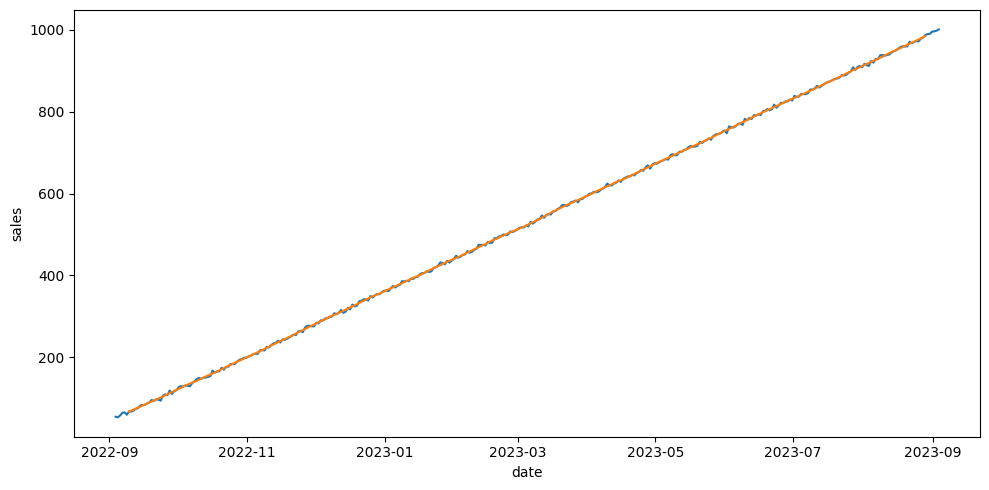

In [33]:
# Analisis de tendencia

tendencia = result.trend

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = sales['sales'])
sns.lineplot(data = tendencia)

plt.tight_layout()

plt.show()

En la gráfica vemos un patrón de crecimiento de las ventas

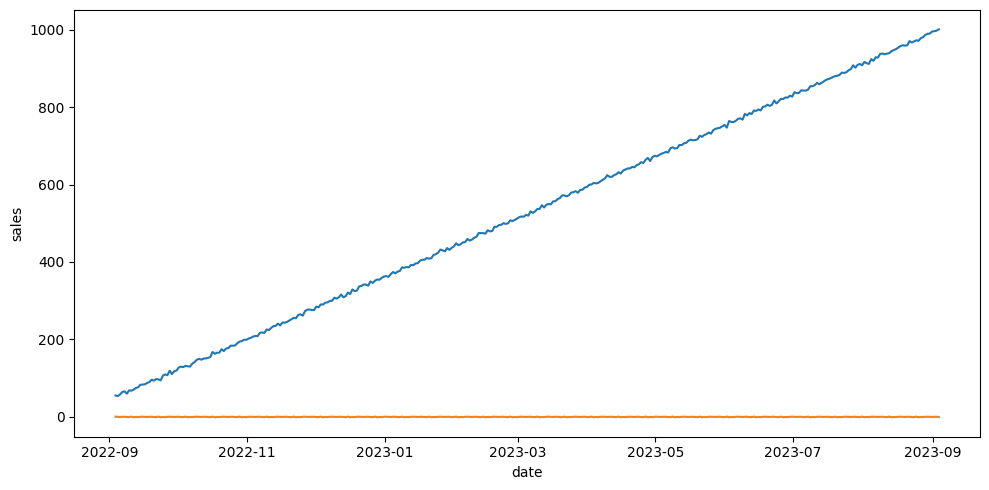

In [34]:
# Analisis de estacionalidad

seasonal = result.seasonal

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = sales['sales'])
sns.lineplot(data = seasonal)

plt.tight_layout()

plt.show()

Para estudiar la estacionalidad de la serie aplicamos el test de Dickey-Fuller

In [35]:

def test_stationarity(timeseries):
    print("Resultados del test de Dickey Fuller:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(sales['sales'])

Resultados del test de Dickey Fuller:


Test Statistic                   0.545414
p-value                          0.986190
#Lags Used                      13.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64

Al comprobar que el valor de p es mayor que 0.05, concluimos que la serie no es estacionaria. Que el valor de Test Statistic sea mayor que los valores críticos refuerza la conclusión de que la serie no es estacionaria

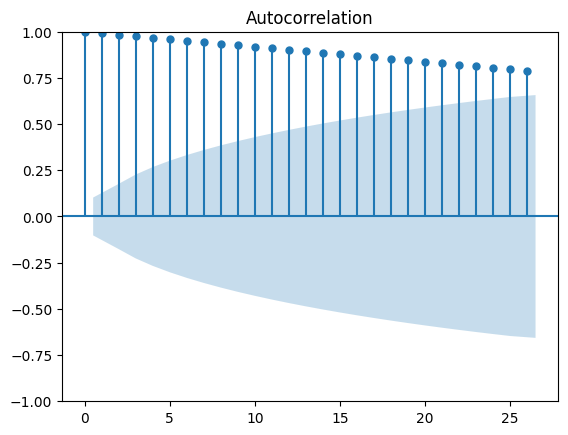

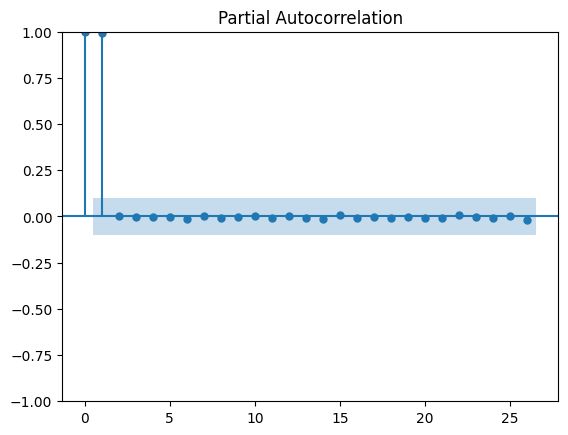

In [7]:

plot_acf(sales['sales'])
plot_pacf(sales['sales'])
plt.show()

De las graficas anteriores podemos sacar los valores de p, d y q para nuestro modelo ARIMA

-p (retardos de la serie): vemos una caída en la gráfica PACF por lo que el valor es 1

-d (diferenciaciones): podemos ver que haría falta un sola difrenciación para que la serie se vuelve estacionaria (p-value<0.05) por lo tanto d = 1

-q (retardos del error): la gráfica ACF no muestra un corte claro, podemos concluir que q = 0

In [59]:

modelo_ventas = ARIMA(sales['sales'], order=(1, 1, 1))  # Reemplazamos p, d, q con los valores obtenidos
modelo_fit = modelo_ventas.fit()


In [62]:

pronostico = modelo_fit.forecast(steps = 240)
pronostico

2023-09-04 17:10:08.079328    1003.052339
2023-09-05 17:10:08.079328    1005.621892
2023-09-06 17:10:08.079328    1008.191445
2023-09-07 17:10:08.079328    1010.760997
2023-09-08 17:10:08.079328    1013.330549
                                 ...     
2024-04-26 17:10:08.079328    1606.881858
2024-04-27 17:10:08.079328    1609.451279
2024-04-28 17:10:08.079328    1612.020699
2024-04-29 17:10:08.079328    1614.590118
2024-04-30 17:10:08.079328    1617.159537
Freq: D, Name: predicted_mean, Length: 240, dtype: float64

Para poder graficar una prediccion de las ventas hemos cambiado el valor de q en el modelo ARIMA por q=1 en lugar de q=0

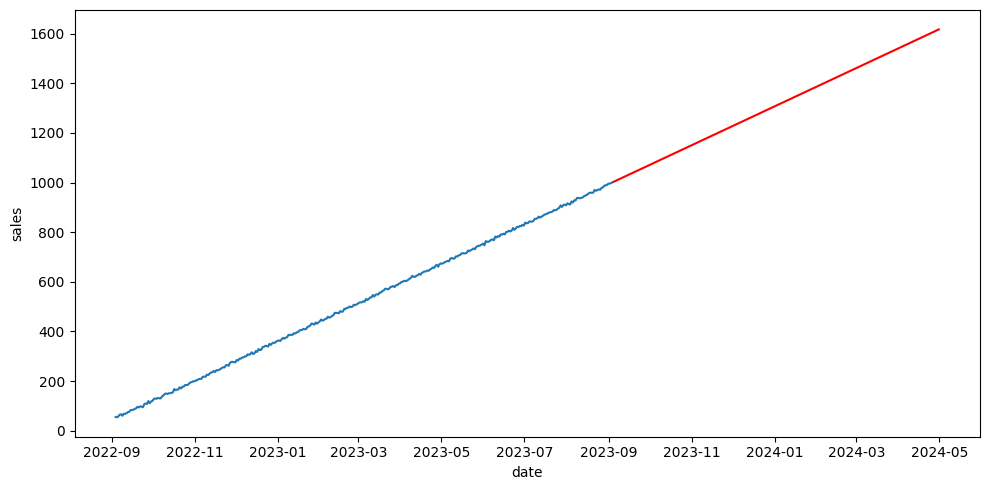

In [63]:
fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = sales['sales'])
sns.lineplot(data = pronostico, c = "red")

plt.tight_layout()

plt.show()

In [64]:
from pickle import dump

dump(modelo_ventas, open ("../models/sales_ARIMA_model.sav", "wb"))